In [110]:
import tensorflow as tf
import os
import random
from sklearn.metrics import f1_score
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import defaultdict
from sklearn.utils import class_weight

Distribusi total kelas
Cystic: 1030
Pustules: 1006
Whiteheads: 299
Blackheads: 1240
Nodules: 97
Papules: 1032


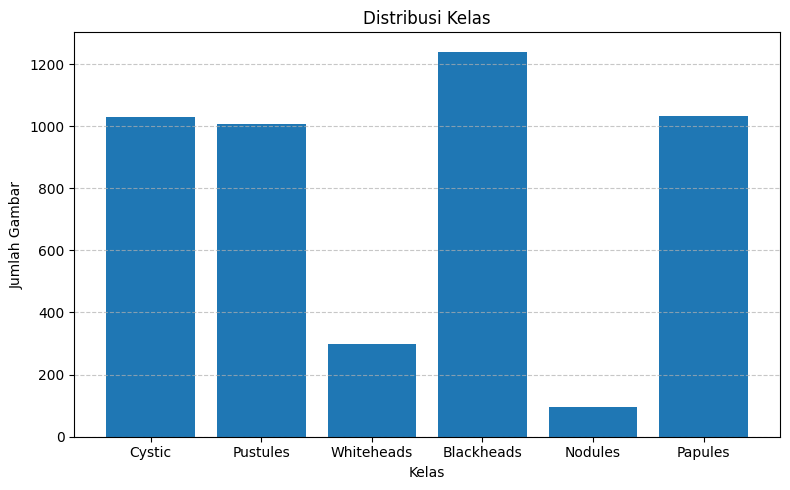

In [111]:

def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_files = len(os.listdir(class_path))
            class_counts[class_name] = num_files
    return class_counts

# Ambil distribusi masing-masing
train_dist = get_class_distribution('/kaggle/input/acne-dataset3/acne-dataset/train')
val_dist = get_class_distribution('/kaggle/input/acne-dataset3/acne-dataset/valid')
test_dist = get_class_distribution('/kaggle/input/acne-dataset3/acne-dataset/test')

# Gabungkan total distribusi
total_dist = defaultdict(int)

for dist in (train_dist, val_dist, test_dist):
    for class_name, count in dist.items():
        total_dist[class_name] += count

# Cetak hasil
print("Distribusi total kelas")
for class_name, total_count in total_dist.items():
    print(f"{class_name}: {total_count}")

# Plot histogram
plt.figure(figsize=(8, 5))
plt.bar(total_dist.keys(), total_dist.values())
plt.title('Distribusi Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Simpan ke file
plt.savefig('/kaggle/working/distribusi_kelas.png')  # <-- ini baris penting

plt.show()


In [112]:
TRAIN_DIR = '/kaggle/input/acne-dataset3/acne-dataset/train'
VAL_DIR = '/kaggle/input/acne-dataset3/acne-dataset/valid'
TEST_DIR = '/kaggle/input/acne-dataset3/acne-dataset/test'
categories = ['Blackheads', 'Cystic', 'Nodules', 'Papules', 'Pustules', 'Whiteheads']

In [113]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=32,
    image_size=(150, 150),
    label_mode="categorical",
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VAL_DIR,
    batch_size=32,
    image_size=(150, 150),
    label_mode="categorical",
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    batch_size=32,
    image_size=(150, 150),
    label_mode="categorical",
)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2830 files belonging to 6 classes.
Found 939 files belonging to 6 classes.
Found 935 files belonging to 6 classes.


In [114]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.02),
    layers.Resizing(height=150, width=150)
])


In [115]:
efficientnet_model = tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

# Freeze the layers of EfficientNetB1 (all kecuali 50 terakhir)
for layer in efficientnet_model.layers[:-50]:
    layer.trainable = True

# Build the custom model
input_layer = layers.Input(shape=(150, 150, 3))
x = data_augmentation(input_layer)
x = efficientnet_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)


In [117]:
class_labels = []
for images, labels in train_dataset:
    class_labels.append(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to class indices

class_labels = np.concatenate(class_labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.6417233560090703, 1: 0.7427821522309711, 2: 7.60752688172043, 3: 0.7595276435856146, 4: 0.807648401826484, 5: 2.4438687392055267}


In [118]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        callbacks=[lr_scheduler, early_stopping],
        class_weight=class_weights
    )

Epoch 1/100


E0000 00:00:1749797364.286300    3469 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_12_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


89/89 ━━━━━━━━━━━━━━━━━━━━ 129s 393ms/step - accuracy: 0.1833 - auc_2: 0.5400 - loss: 6.2017 - precision_6: 0.1882 - recall_6: 0.1239 - val_accuracy: 0.3759 - val_auc_2: 0.7134 - val_loss: 5.0457 - val_precision_6: 1.0000 - val_recall_6: 0.0043 - learning_rate: 1.0000e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.2720 - auc_2: 0.6233 - loss: 5.5508 - precision_6: 0.3005 - recall_6: 0.2075 - val_accuracy: 0.3834 - val_auc_2: 0.7253 - val_loss: 4.9613 - val_precision_6: 0.7887 - val_recall_6: 0.0596 - learning_rate: 1.0000e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.3166 - auc_2: 0.6722 - loss: 5.3329 - precision_6: 0.3431 - recall_6: 0.2446 - val_accuracy: 0.4239 - val_auc_2: 0.7468 - val_loss: 4.8785 - val_precision_6: 0.6653 - val_recall_6: 0.1757 - learning_rate: 1.0000e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.3672 - auc_2: 0.7194 - loss: 5.0526 - precision_6: 0.4205 - recall_6: 0.3035 - val_accuracy

In [119]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Blackheads', 'Cystic', 'Nodules', 'Papules', 'Pustules', 'Whiteheads']

y_true = []
y_pred = []

# Prediksi pada test_dataset
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Buat classification report
report = classification_report(
    y_true, y_pred, target_names=class_names, digits=4
)

# Tampilkan dan simpan
print("Classification Report:\n")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━

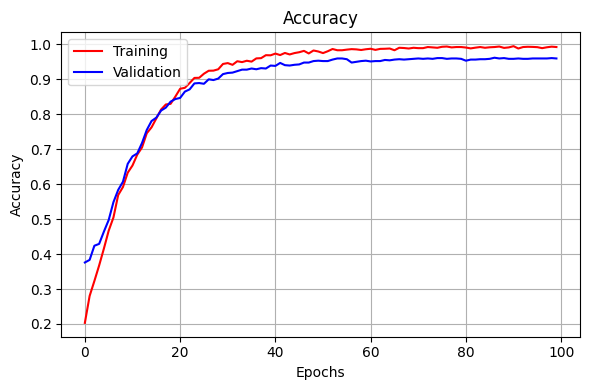

In [120]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/acc_plot.png')
plt.show()


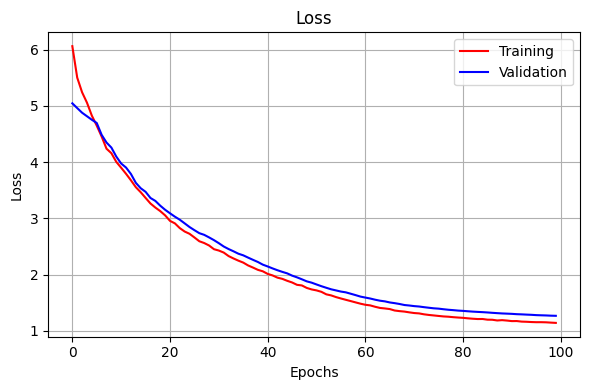

In [121]:
# Get training and validation losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/val_plot.png')
plt.show()


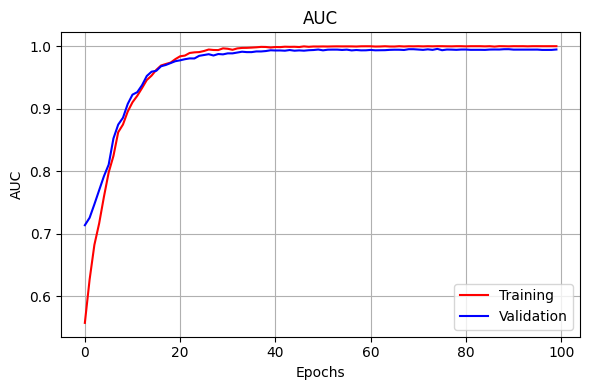

In [129]:
# Get training and validation auc
auc = history.history['auc_2']
val_auc = history.history['val_auc_2']
epochs = range(len(auc))

# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(epochs, auc, 'r', label='Training')
plt.plot(epochs, val_auc, 'b', label='Validation')
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/auc_plot.png')
plt.show()



In [125]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test ROC AUC: {test_auc}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9572 - auc_2: 0.9972 - loss: 1.2711 - precision_6: 0.9577 - recall_6: 0.9564
Test Accuracy: 0.959358274936676
Test Precision: 0.9612902998924255
Test Recall: 0.9561497569084167
Test ROC AUC: 0.9961900115013123


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
Test Set F1 Score: 0.9490719845249088


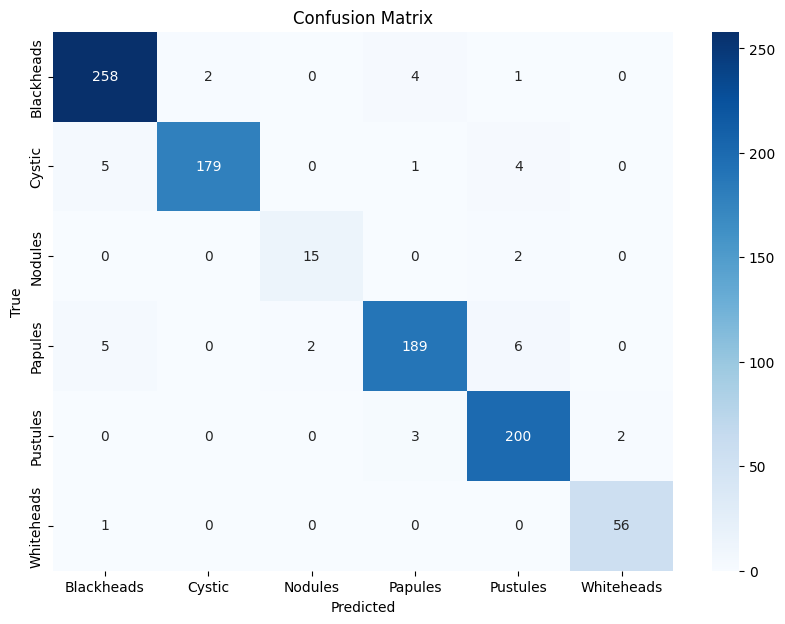

In [130]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

categories = categories

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
print(f"Test Set F1 Score: {f1}")

cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [184]:
def infer_and_display(image_path, model, categories, actual_label=None):
    try:
        # Load image
        if image_path.startswith("http://") or image_path.startswith("https://"):
            response = requests.get(image_path)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_path)

        # Ensure RGB and resize
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_resized = img.resize((150, 150))

        # Convert to array and preprocess
        img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Predict
        predictions = model.predict(img_array, verbose=0)
        top_3_indices = np.argsort(predictions[0])[-3:][::-1]

        # Output Top 3
        print("\nTop 3 Predictions:")
        for idx in top_3_indices:
            print(f"{categories[idx]}: {predictions[0][idx]:.2%}")

        # Final result
        predicted_class_index = np.argmax(predictions[0])
        predicted_category = categories[predicted_class_index]
        confidence_score = float(predictions[0][predicted_class_index])

        # Display image
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        title = f"Predicted: {predicted_category}\nConfidence: {confidence_score:.2%}"
        plt.title(title, fontsize=12, pad=20)

        # Save if actual_label provided
        if actual_label:
            save_path = f"/kaggle/working/{actual_label}.png"
            plt.savefig(save_path, bbox_inches='tight')
            print(f"\nImage saved to {save_path}")

        plt.show()

        # Print analysis
        print(f"\nDetailed Analysis:")
        if actual_label:
            print(f"Actual Category: {actual_label}")
        print(f"Predicted Category: {predicted_category}")
        print(f"Confidence Score: {confidence_score:.2%}")

    except Exception as e:
        print(f"Error: {str(e)}")



Top 3 Predictions:
Blackheads: 99.95%
Whiteheads: 0.02%
Nodules: 0.01%

Image saved to /kaggle/working/Blackhead.png


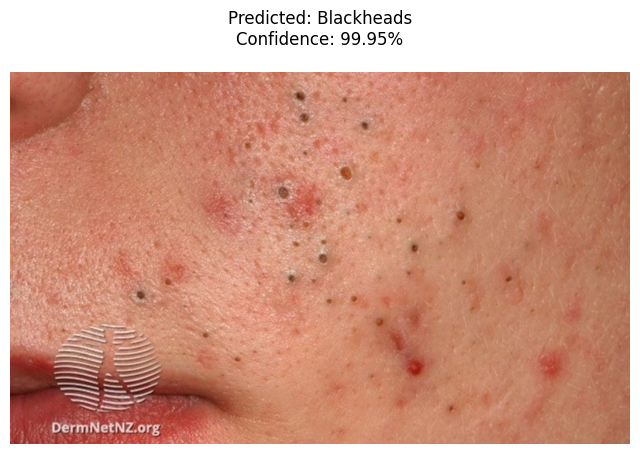


Detailed Analysis:
Actual Category: Blackhead
Predicted Category: Blackheads
Confidence Score: 99.95%


In [187]:
# Example Blackhead
image_path = "https://appnhs24wp41a8c38064.blob.core.windows.net/blobappnhs24wp41a8c38064/wp-content/uploads/2023/02/acne-2.jpg"
jenis = "Blackhead"

infer_and_display(image_path, model, categories, actual_label=jenis)



Top 3 Predictions:
Cystic: 99.79%
Pustules: 0.17%
Nodules: 0.03%

Image saved to /kaggle/working/Cystic.png


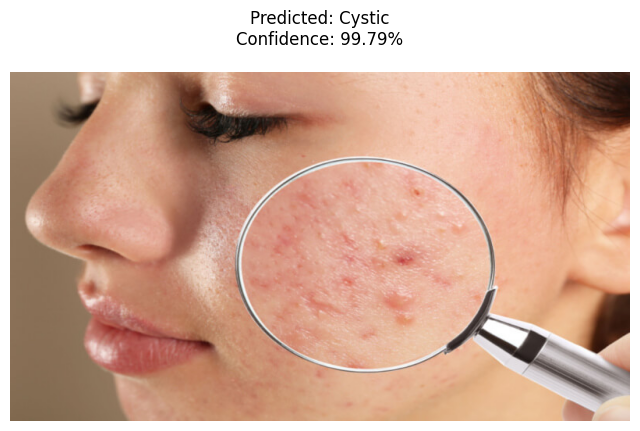


Detailed Analysis:
Actual Category: Cystic
Predicted Category: Cystic
Confidence Score: 99.79%


In [195]:
# Example Cystic
image_path = "https://skincancer-specialists.com/wp-content/uploads/2022/10/acne-1.jpg"
jenis = "Cystic"

infer_and_display(image_path, model, categories, actual_label=jenis)


Top 3 predictions:
Nodules: 82.94%
Pustules: 8.43%
Whiteheads: 4.66%

Image saved to /kaggle/working/Nodules.png


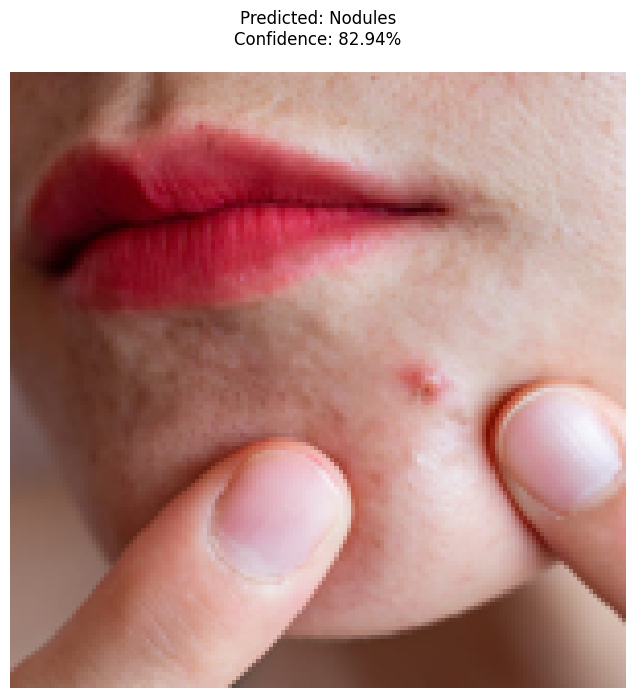


Detailed Analysis:
Predicted Category: Nodules
Confidence Score: 82.94%


In [172]:
# Example Nodules
image_path = "https://hips.hearstapps.com/hmg-prod/images/cropped-shot-of-woman-pointing-to-acne-occur-on-her-royalty-free-image-1671226766.jpg?crop=0.668xw:1.00xh;0.0986xw,0&resize=640:*"
jenis = "Nodules"

infer_and_display(image_path, model, categories, actual_label=jenis)


Top 3 Predictions:
Papules: 65.80%
Cystic: 18.42%
Pustules: 8.79%

Image saved to /kaggle/working/Papules.png


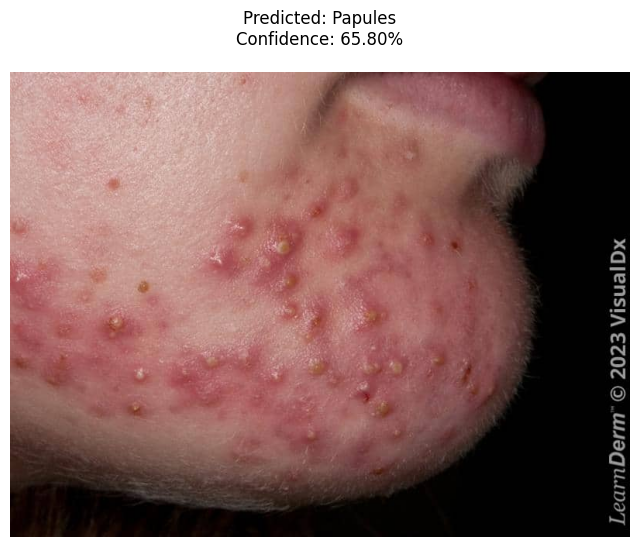


Detailed Analysis:
Actual Category: Papules
Predicted Category: Papules
Confidence Score: 65.80%


In [189]:
# Example Papules
image_path = "https://www.learnderm.com/wp-content/uploads/2023/09/L02_fluid-filled_pustule_light-skin_acne-vulgaris_90224.jpg"
jenis = "Papules"
infer_and_display(image_path, model, categories, actual_label=jenis)


Top 3 Predictions:
Pustules: 48.37%
Papules: 44.11%
Cystic: 6.97%

Image saved to /kaggle/working/Pustules.png


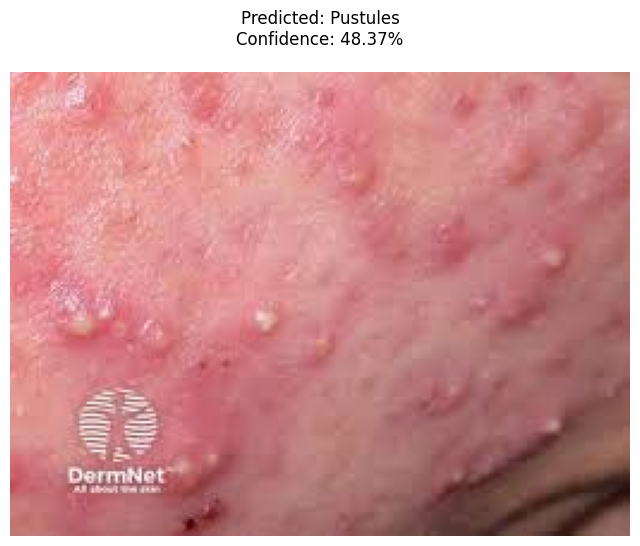


Detailed Analysis:
Actual Category: Pustules
Predicted Category: Pustules
Confidence Score: 48.37%


In [197]:
# Example Pustules
jenis = "Pustules"
image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRM1ScD3p8TiWdUopX2W3maDYhJirP7q705Q&s"
infer_and_display(image_path, model, categories, actual_label=jenis)


Top 3 Predictions:
Whiteheads: 99.81%
Blackheads: 0.18%
Nodules: 0.01%

Image saved to /kaggle/working/Whiteheads.png


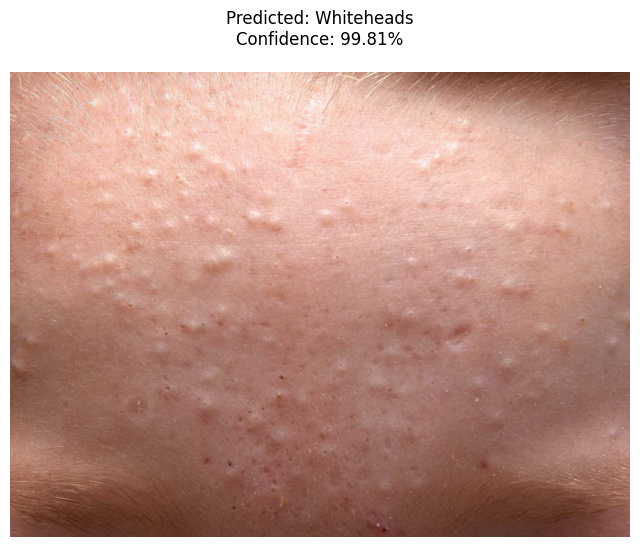


Detailed Analysis:
Actual Category: Whiteheads
Predicted Category: Whiteheads
Confidence Score: 99.81%


In [191]:
# Example Whiteheads
jenis = "Whiteheads"
image_path = "https://www.health.com/thmb/U2Pj7HrlmfbOhYW4LFfPtYrgNBk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Health-133.acne-001-5569be33e2174af18cc1513bdfa52610.jpeg"
infer_and_display(image_path, model, categories, actual_label=jenis)

In [162]:
model.save('model.keras')

In [163]:
model = tf.keras.models.load_model("model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_lx81rwu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_18')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140417226276944: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140417226288080: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140423499001936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423499002512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423499000016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423498999248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423499002704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423498999632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423499000976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140423498999824: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1749800926.471216    3469 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749800926.471276    3469 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749800926.727352    3469 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [198]:
!zip -r /kaggle/working/output.zip /kaggle/working/*

from IPython.display import FileLink
FileLink(r'/kaggle/working/output.zip')


updating: kaggle/working/acc_plot.png (deflated 9%)
updating: kaggle/working/auc_plot.png (deflated 8%)
updating: kaggle/working/distribusi_kelas.png (deflated 21%)
updating: kaggle/working/model.keras (deflated 10%)
updating: kaggle/working/model.tflite (deflated 7%)
updating: kaggle/working/val_plot.png (deflated 6%)
  adding: kaggle/working/Blackhead.png (deflated 0%)
  adding: kaggle/working/Cystic.png (deflated 0%)
  adding: kaggle/working/Nodules.png (deflated 6%)
  adding: kaggle/working/Papules.png (deflated 0%)
  adding: kaggle/working/Pustules.png (deflated 0%)
  adding: kaggle/working/Whiteheads.png (deflated 0%)


/kaggle/working/output.zip